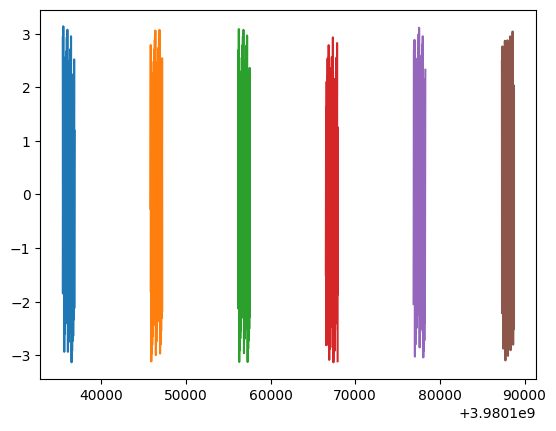

In [92]:
import numpy as np
import matplotlib.pyplot as plt

frame_num = 2

rx1_pkt_array = np.load('data/rx1_data_{}.npz'.format(frame_num), allow_pickle=True)['arr_0']
rx2_pkt_array = np.load('data/rx2_data_{}.npz'.format(frame_num), allow_pickle=True)['arr_0']

plt.figure()
for i in range(6):
    time_index = [rx1_pkt_array[i]['timestamp'] + j*16 for j in range(len(rx1_pkt_array[i]['I_data']))]
    phase = np.arctan2(rx1_pkt_array[i]['Q_data'], rx1_pkt_array[i]['I_data'])
    plt.plot(time_index, phase, label='rx1_pkt_{}'.format(i))
plt.show()

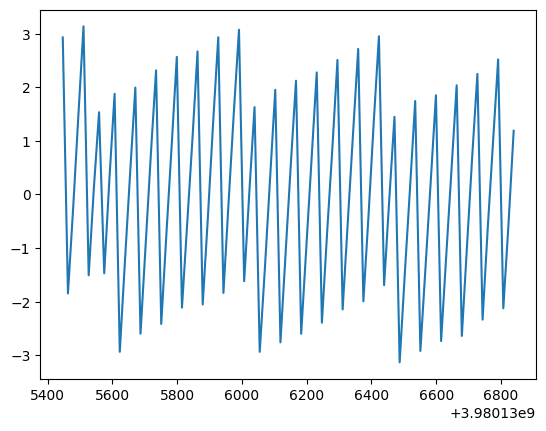

In [93]:
plt.figure()
for i in range(1):
    time_index = [rx1_pkt_array[i]['timestamp'] + j*16 for j in range(len(rx1_pkt_array[i]['I_data']))]
    phase = np.arctan2(rx1_pkt_array[i]['Q_data'], rx1_pkt_array[i]['I_data'])
    plt.plot(time_index, phase, label='rx1_pkt_{}'.format(i))
plt.show()

35.0 -166.0
-43.0 159.0
153.0 60.0
-156.0 11.0
-151.0 -78.0
123.0 -164.0


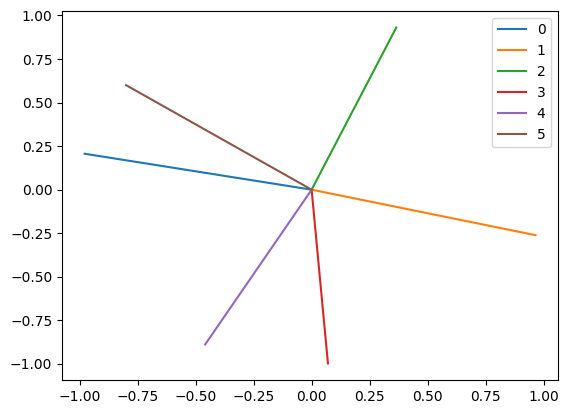

In [94]:
plt.figure()
for i in range(6):
    I = rx1_pkt_array[i]['I_data'][0]
    Q = rx1_pkt_array[i]['Q_data'][0]
    magnitude = np.sqrt(I**2 + Q**2)
    I = I/magnitude
    Q = Q/magnitude
    plt.plot([0, I], [0, Q], label = i)
    print(rx1_pkt_array[i]['Q_data'][0], rx1_pkt_array[i]['I_data'][0])

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


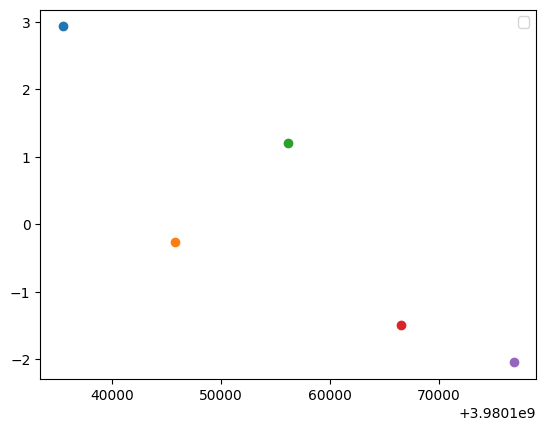

[0, 10361, 20721, 31081, 41443]
[0, 10361, 20721, 31081, 41443]
正斜率最优解:
  最佳 R²: 0.974532
  最佳补偿倍数: (-2, 0, 0, 2, 2)
  最佳斜率: 0.000531

负斜率最优解:
  最佳 R²: 0.987850
  最佳补偿倍数: (1, 1, -1, -1, -2)
  最佳斜率: -0.000561
总体最优方向: negative (R² = 0.987850)

正斜率是否存在线性关系: True
负斜率是否存在线性关系: True


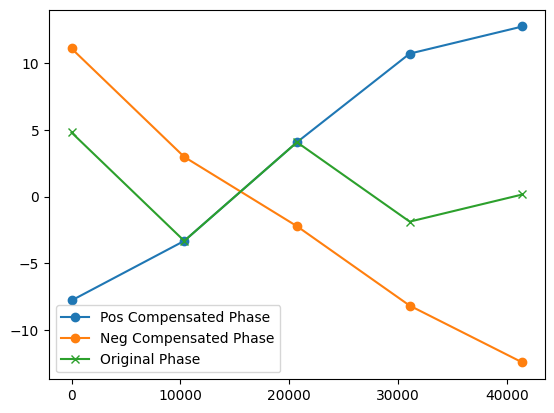

In [95]:
plt.figure()
for i in range(5):
    I = rx1_pkt_array[i]['I_data'][0]
    Q = rx1_pkt_array[i]['Q_data'][0]
    phase = np.arctan2(Q, I)
    plt.plot(rx1_pkt_array[i]['timestamp'], phase, 'o-')

plt.legend()
plt.show()

rx1_phase_list = [np.arctan2(rx1_pkt_array[i]['Q_data'][0], rx1_pkt_array[i]['I_data'][0]) for i in range(5)]
rx2_phase_list = [np.arctan2(rx2_pkt_array[i]['Q_data'][0], rx2_pkt_array[i]['I_data'][0]) for i in range(5)]
rx1_timestamp_list = [rx1_pkt_array[i]['timestamp'] for i in range(5)]
rx2_timestamp_list = [rx2_pkt_array[i]['timestamp'] for i in range(5)]

rx1_timestamp_init = rx1_timestamp_list[0]
rx2_timestamp_init = rx2_timestamp_list[0]
for i in range(5):
    rx1_timestamp_list[i] = rx1_timestamp_list[i] - rx1_timestamp_init
    rx2_timestamp_list[i] = rx2_timestamp_list[i] - rx2_timestamp_init

print(rx1_timestamp_list)
print(rx2_timestamp_list)

phase_diff = np.array(rx1_phase_list) - np.array(rx2_phase_list)

import numpy as np
from scipy import stats
import itertools

def check_linearity_with_phase_unwrap_dual(timestamps, phases, max_k=3, r_squared_threshold=0.98):
    """
    检查在2π补偿下是否存在线性关系，分别拟合正负斜率的最优解
    max_k: 每个点最多补偿的2π倍数范围 [-max_k, max_k]
    """
    n_points = len(phases)
    
    # 生成所有可能的补偿组合
    k_combinations = list(itertools.product(range(-max_k, max_k+1), repeat=n_points))
    
    # 分别存储正负斜率的最优解
    best_positive = {
        'r_squared': -1,
        'k_values': None,
        'slope': None,
        'intercept': None
    }
    
    best_negative = {
        'r_squared': -1,
        'k_values': None,
        'slope': None,
        'intercept': None
    }
    
    for k_vec in k_combinations:
        # 应用补偿
        compensated_phases = phases + np.array(k_vec) * 2 * np.pi
        
        # 线性拟合
        if len(np.unique(timestamps)) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(timestamps, compensated_phases)
            r_squared = r_value ** 2
            
            # 根据斜率正负分别更新最优解
            if slope >= 0:  # 正斜率
                if r_squared > best_positive['r_squared']:
                    best_positive['r_squared'] = r_squared
                    best_positive['k_values'] = k_vec
                    best_positive['slope'] = slope
                    best_positive['intercept'] = intercept
            else:  # 负斜率
                if r_squared > best_negative['r_squared']:
                    best_negative['r_squared'] = r_squared
                    best_negative['k_values'] = k_vec
                    best_negative['slope'] = slope
                    best_negative['intercept'] = intercept
    
    # 输出结果
    print("=" * 50)
    print("正斜率最优解:")
    print(f"  最佳 R²: {best_positive['r_squared']:.6f}")
    print(f"  最佳补偿倍数: {best_positive['k_values']}")
    print(f"  最佳斜率: {best_positive['slope']:.6f}")
    
    print("\n负斜率最优解:")
    print(f"  最佳 R²: {best_negative['r_squared']:.6f}")
    print(f"  最佳补偿倍数: {best_negative['k_values']}")
    print(f"  最佳斜率: {best_negative['slope']:.6f}")
    print("=" * 50)
    
    # 判断哪个方向的线性关系更好
    if best_positive['r_squared'] > best_negative['r_squared']:
        best_direction = 'positive'
        best_overall = best_positive
    else:
        best_direction = 'negative'
        best_overall = best_negative
    
    print(f"总体最优方向: {best_direction} (R² = {best_overall['r_squared']:.6f})")
    
    # 判断是否存在强线性关系
    is_linear_positive = best_positive['r_squared'] > r_squared_threshold
    is_linear_negative = best_negative['r_squared'] > r_squared_threshold
    is_linear_overall = best_overall['r_squared'] > r_squared_threshold
    
    return (is_linear_positive, is_linear_negative, is_linear_overall, 
            best_positive, best_negative, best_overall, best_direction)


timestamps = rx1_timestamp_list
phases = phase_diff

(is_linear_pos, is_linear_neg, is_linear_overall, 
 best_pos, best_neg, best_overall, direction) = check_linearity_with_phase_unwrap_dual(
    timestamps, phases, max_k=2, r_squared_threshold=0.95
)

print(f"\n正斜率是否存在线性关系: {is_linear_pos}")
print(f"负斜率是否存在线性关系: {is_linear_neg}")

pos_new_phase_list = []
for i in range(5):
    pos_new_phase_list.append(phase_diff[i] + best_pos['k_values'][i] * 2 * np.pi)

neg_new_phase_list = []
for i in range(5):
    neg_new_phase_list.append(phase_diff[i] + best_neg['k_values'][i] * 2 * np.pi)

plt.figure()
plt.plot(timestamps, pos_new_phase_list, 'o-', label='Pos Compensated Phase')
plt.plot(timestamps, neg_new_phase_list, 'o-', label='Neg Compensated Phase')
plt.plot(timestamps, phase_diff, 'x-', label='Original Phase')
plt.legend()
plt.show()

0.9699161539150865
-0.3717570069380898
[ 4.2372146  -1.9943591  -1.8709683  -1.7869564   4.5070643  -1.6824026
 -1.7433637  -1.6284871  -1.4956995  -1.5280045   4.911235   -1.3725194
 -1.2576098  -1.2773521   5.1537833  -1.1480578  -1.055484   -0.95706743
  5.431797   -0.8710774  -0.8490275  -0.76975834  5.5617     -0.71492684
 -0.6478708  -0.5951673  -0.521456   -0.3999369  -0.39010894 -0.36958814
 -0.22773767 -0.25313222 -0.20149076 -0.16171551 -0.03446031 -0.03798336
  0.05859208  0.20348907  0.17779326  0.18335146  0.24140441  0.318146
  0.4315158   0.38534614  0.45708835 -5.800782    0.5802454   0.6804007
  0.7516633  -5.4875813   0.7840283   0.7737409   0.8671856  -5.3452253
  1.0496254   1.1063155   1.2064573  -5.054104    1.1650459   1.344711
  1.3568658   1.4036944   1.5105981   1.5674648  -4.671803    1.5923101
  1.6933498   1.8287572  -4.4325314   1.9295044   1.976932    2.0150235
 -4.288388    2.090735    2.1822543   2.185261   -4.0843587   2.2714727
  2.4106307   2.473002 

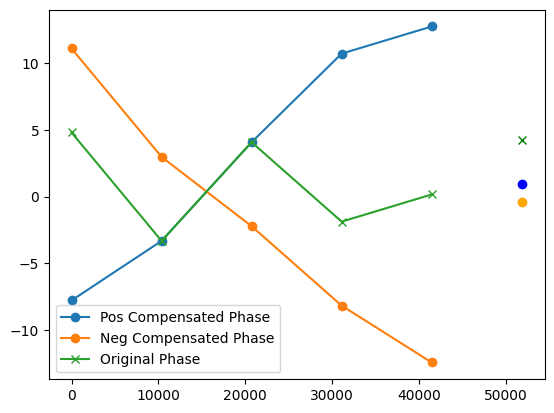

In [96]:
pos_intercept = np.mean(pos_new_phase_list) - best_pos['slope'] * np.mean(rx1_timestamp_list)
neg_intercept = np.mean(neg_new_phase_list) - best_neg['slope'] * np.mean(rx1_timestamp_list)
pos_tx2_phase_delta = pos_intercept + best_pos['slope'] * (rx1_pkt_array[5]['timestamp'] - rx1_timestamp_init)
neg_tx2_phase_delta = neg_intercept + best_neg['slope'] * (rx1_pkt_array[5]['timestamp'] - rx1_timestamp_init)

def comp_2pi(tx2_phase_delta):
    while tx2_phase_delta > 2*np.pi or tx2_phase_delta < -2*np.pi:
        if tx2_phase_delta > 2*np.pi:
            tx2_phase_delta = tx2_phase_delta - 2*np.pi
        else:
            tx2_phase_delta = tx2_phase_delta + 2*np.pi
    
    # if tx2_phase_delta > np.pi:
    #     tx2_phase_delta = tx2_phase_delta - 2*np.pi
    # elif tx2_phase_delta < -np.pi:
    #     tx2_phase_delta = tx2_phase_delta + 2*np.pi
    return tx2_phase_delta

pos_tx2_phase_delta = comp_2pi(pos_tx2_phase_delta)
neg_tx2_phase_delta = comp_2pi(neg_tx2_phase_delta)

print(pos_tx2_phase_delta)
print(neg_tx2_phase_delta)

print(np.arctan2(rx1_pkt_array[5]['Q_data'], rx1_pkt_array[5]['I_data']) - np.arctan2(rx2_pkt_array[5]['Q_data'], rx2_pkt_array[5]['I_data']))

plt.figure()
plt.plot(timestamps, pos_new_phase_list, 'o-', label='Pos Compensated Phase')
plt.plot(timestamps, neg_new_phase_list, 'o-', label='Neg Compensated Phase')
plt.plot(timestamps, phase_diff, 'x-', label='Original Phase')
plt.plot(rx1_pkt_array[5]['timestamp'] - rx1_timestamp_init, np.arctan2(rx1_pkt_array[5]['Q_data'][0], rx1_pkt_array[5]['I_data'][0]) - np.arctan2(rx2_pkt_array[5]['Q_data'][0], rx2_pkt_array[5]['I_data'][0]), 'x-', c='g')
plt.plot(rx1_pkt_array[5]['timestamp'] - rx1_timestamp_init, pos_tx2_phase_delta, 'o-', c='b')
plt.plot(rx1_pkt_array[5]['timestamp'] - rx1_timestamp_init, neg_tx2_phase_delta, 'o-', c='orange')
plt.legend()
plt.show()

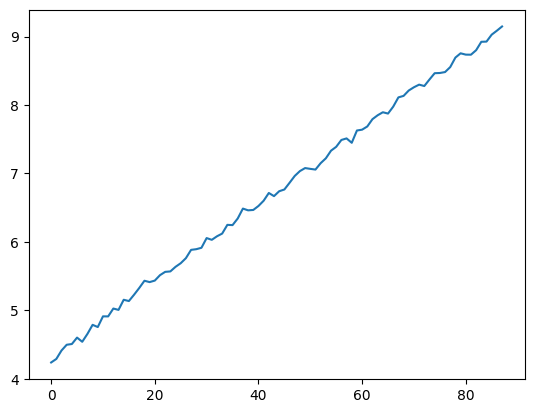

In [97]:
tx2_phase_diff = np.arctan2(rx1_pkt_array[5]['Q_data'], rx1_pkt_array[5]['I_data']) - np.arctan2(rx2_pkt_array[5]['Q_data'], rx2_pkt_array[5]['I_data'])

plt.figure()
plt.plot(np.unwrap(tx2_phase_diff))
plt.show()

In [98]:
pos_tx2_phase_diff = tx2_phase_diff - pos_tx2_phase_delta
neg_tx2_phase_diff = tx2_phase_diff - neg_tx2_phase_delta


pos_x1 = pos_tx2_phase_diff[0]
neg_x1 = neg_tx2_phase_diff[0]

def comp_pi(x1):
    while x1 > np.pi or x1 < -np.pi:
        if x1 > np.pi:
            x1 = x1 - 2 * np.pi
        elif x1 < -np.pi:
            x1 = x1 + 2 * np.pi
    return x1
pos_x1 = comp_pi(pos_x1)
neg_x1 = comp_pi(neg_x1)

print(pos_x1)
print(neg_x1)

pos_x1 = pos_x1/6.28*12.5/6
neg_x1 = neg_x1/6.28*12.5/6
print('pos_angle1:', np.arcsin(pos_x1)/np.pi*180)
print('neg_angle1:', np.arcsin(neg_x1)/np.pi*180)

-3.0158868471728724
-1.674213711415426
pos_angle1: nan
neg_angle1: -33.738634806397016


C:\Users\11422\AppData\Local\Temp\ipykernel_10980\1697293639.py:23: RuntimeWarning: invalid value encountered in arcsin
  print('pos_angle1:', np.arcsin(pos_x1)/np.pi*180)
